In [ ]:
#| default_exp models.deepnpts

# DeepNPTS

Deep Non-Parametric Time Series Forecaster (`DeepNPTS`) is a non-parametric baseline model for time-series forecasting. This model generates predictions by sampling from the empirical distribution according to a tunable strategy. This strategy is learned by exploiting the information across multiple related time series. This model provides a strong, simple baseline for time series forecasting.


**References**<br>
[Rangapuram, Syama Sundar, Jan Gasthaus, Lorenzo Stella, Valentin Flunkert, David Salinas, Yuyang Wang, and Tim Januschowski (2023). "Deep Non-Parametric Time Series Forecaster". arXiv.](https://arxiv.org/abs/2312.14657)<br>


:::{.callout-warning collapse="false"}
#### Exogenous Variables, Losses, and Parameters Availability

Given the sampling procedure during inference, DeepNPTS only supports `DistributionLoss` as training loss.

Note that DeepNPTS generates a non-parametric forecast distribution using Monte Carlo. We use this sampling procedure also during validation to make it closer to the inference procedure. Therefore, only the `MQLoss` is available for validation.

Aditionally, Monte Carlo implies that historic exogenous variables are not available for the model.
:::

In [ ]:
#| export
import numpy as np

import torch
import torch.nn as nn
import neuralforecast.losses.pytorch as losses
from typing import Optional
from functools import partial


from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.losses.pytorch import MQLoss, GMM, PMM, NBMM


In [ ]:
#| hide
import logging
import warnings

from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| hide
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

## 2. DeepNPTS

In [ ]:
#| export
class DeepNPTS(BaseWindows):
    """ DeepNPTS

    Deep Non-Parametric Time Series Forecaster (`DeepNPTS`) is a baseline model for time-series forecasting. This model generates predictions by sampling from the empirical distribution according to a learnable strategy. The strategy is learned by exploiting the information across multiple related time series. 

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `hidden_size`: int=32, hidden size of dense layers.<br>
    `batch_norm`: bool=True, if True, applies Batch Normalization after each dense layer in the network.<br>
    `dropout`: float=0.1, dropout.<br>
    `n_layers`: int=2, number of dense layers.<br>
    `trajectory_samples`: int=100, number of Monte Carlo trajectories during inference.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>
    - [Rangapuram, Syama Sundar, Jan Gasthaus, Lorenzo Stella, Valentin Flunkert, David Salinas, Yuyang Wang, and Tim Januschowski (2023). "Deep Non-Parametric Time Series Forecaster". arXiv.](https://arxiv.org/abs/2312.14657)<br>

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    
    def __init__(self,
                 h,
                 input_size: int = -1,
                 hidden_size: int = 32,
                 batch_norm: bool = True,
                 dropout: float = 0.1,
                 n_layers: int = 2,
                 trajectory_samples: int = 100,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = GMM(),
                 valid_loss = MQLoss(level=[80, 90]),
                 max_steps: int = 1000,
                 learning_rate: float = 1e-5,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = -1,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'standard',
                 random_seed: int = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 **trainer_kwargs):

        if hist_exog_list is not None:
            raise Exception('DeepNPTS does not support historical exogenous variables.')

        if exclude_insample_y:
            raise Exception('DeepNPTS has no possibility for excluding y.')
        
        supported_losses = (losses.GMM,
                            losses.PMM,
                            losses.NBMM)

        if not isinstance(loss, supported_losses):
            raise Exception('DeepNPTS only supports GMM, PMM or NBMM as loss function.')               
        
        if not isinstance(valid_loss, losses.MQLoss):
            raise Exception('DeepNPTS only supports MQLoss as validation loss.')
    
        # Overwrite n_components, it has to be the input_size in DeepNPTS
        loss.n_components = input_size
        
        # Inherit BaseWindows class
        super(DeepNPTS, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    valid_batch_size=valid_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    start_padding_enabled=start_padding_enabled,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    optimizer=optimizer,
                                    optimizer_kwargs=optimizer_kwargs,
                                    **trainer_kwargs)

        self.h = h
        self.h_backup = self.h                                  # Used because h=1 during training
        self.use_softmax = True
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.trajectory_samples = trajectory_samples

        self.futr_exog_size = len(self.futr_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)

        input_dim = input_size * (1 + self.futr_exog_size) + self.stat_exog_size
        # Create DeepNPTSNetwork
        modules = []       
        for i in range(n_layers):
            modules.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
            modules.append(nn.ReLU())
            if batch_norm:
                modules.append(nn.BatchNorm1d(hidden_size))
            if dropout > 0.0:
                modules.append(nn.Dropout(dropout))

        self.deepnptsnetwork = nn.Sequential(*modules)
        self.deepnptsnetwork.apply(partial(self._init_weights, scale=0.07))

        # Add output layers for Mixture distribution        
        output_modules = []
        if dropout > 0.0:
            output_modules.append(nn.Dropout(self.dropout))
        
        if isinstance(loss, GMM):
            output_modules.append(nn.Linear(hidden_size, input_size + 1))
        elif isinstance(loss, PMM):
            output_modules.append(nn.Linear(hidden_size, input_size))
        elif isinstance(loss, NBMM):
            output_modules.append(nn.Linear(hidden_size, input_size))

        self.output_layer = nn.Sequential(*output_modules)
        self.output_layer.apply(self._init_weights)


    @staticmethod
    def _init_weights(module, scale=1.0):
        if type(module) == nn.Linear:
            nn.init.uniform_(module.weight, -scale, scale)
            nn.init.zeros_(module.bias)

    def _domain_map(self, o_t, insample_y):
        if isinstance(self.loss, GMM):
            weights = o_t[:, :-1]                                             #   [B, L + 1] -> [B, L]
            kernel_width = o_t[:, -1:]                                        #   [B, L + 1] -> [B, 1]
            kernel_width = torch.repeat_interleave(input=kernel_width,
                                                   repeats=weights.shape[1],
                                                   dim=-1)                    #   [B, 1] -> [B, L]
            output = torch.cat([insample_y, kernel_width, weights], dim=-1)   #   [B, L] + [B, L] + [B, L] = [B, 3 * L]
            output = output.unsqueeze(1)                                      #   [B, 3 * L] = [B, 1, 3 * L]
        elif isinstance(self.loss, PMM):
            weights = o_t                                                     #   [B, L] -> [B, L]
            output = torch.cat([insample_y, weights], dim=-1)                 #   [B, L] + [B, L] = [B, 2 * L]
            output = output.unsqueeze(1)                                      #   [B, 2 * L] = [B, 1, 2 * L]        
        elif isinstance(self.loss, NBMM):
            weights = torch.ones_like(o_t)                                    #   [B, L] -> [B, L]
            output = torch.cat([insample_y, o_t, weights], dim=-1)            #   [B, L] + [B, L] + [B, L] = [B, 3 * L]
            output = output.unsqueeze(1)                                      #   [B, 3 * L] = [B, 1, 3 * 

        else:
            raise NotImplementedError
        
        return output

    # Override BaseWindows method
    def training_step(self, batch, batch_idx):
        
        # Only train one-step ahead
        self.h = 1
        self.quantiles = self.loss.quantiles

        # Create and normalize windows [Ws, L+H, C]
        y_idx = batch["y_idx"]
        windows = self._create_windows(batch, step="train")
        original_outsample_y = torch.clone(windows["temporal"][:, -self.h :, y_idx])
        windows = self._normalization(windows=windows, y_idx=y_idx)

        # Parse windows
        (
            insample_y,
            insample_mask,
            outsample_y,
            outsample_mask,
            _,
            futr_exog,
            stat_exog,
        ) = self._parse_windows(batch, windows)

        windows_batch = dict(
            insample_y=insample_y,  # [Ws, L]
            insample_mask=insample_mask,  # [Ws, L]
            futr_exog=futr_exog,  # [Ws, L+H]
            hist_exog=None,  
            stat_exog=stat_exog, # [Ws, 1]
            y_idx=y_idx # [Ws, 1]
        )  

        # Model Predictions
        output = self.train_forward(windows_batch)

        _, y_loc, y_scale = self._inv_normalization(
            y_hat=outsample_y, 
            temporal_cols=batch["temporal_cols"], 
            y_idx=y_idx
        )
        # outsample_y = original_insample_y
        outsample_y = original_outsample_y
        distr_args = self.loss.scale_decouple(
            output=output, loc=y_loc, scale=y_scale
        )
        loss = self.loss(y=outsample_y, distr_args=distr_args, mask=outsample_mask)

        if torch.isnan(loss):
            print("Model Parameters", self.hparams)
            print("insample_y", torch.isnan(insample_y).sum())
            print("outsample_y", torch.isnan(outsample_y).sum())
            print("output", torch.isnan(output).sum())
            raise Exception("Loss is NaN, training stopped.")

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.train_trajectories.append((self.global_step, float(loss)))

        self.h = self.h_backup 
        
        return loss

    # Override BaseWindows method
    def validation_step(self, batch, batch_idx):

        self.h = self.h_backup
        self.quantiles = self.valid_loss.quantiles

        if self.val_size == 0:
            return np.nan

        # TODO: Hack to compute number of windows
        windows = self._create_windows(batch, step="val")
        n_windows = len(windows["temporal"])
        y_idx = batch["y_idx"]

        # Number of windows in batch
        windows_batch_size = self.inference_windows_batch_size
        if windows_batch_size < 0:
            windows_batch_size = n_windows
        n_batches = int(np.ceil(n_windows / windows_batch_size))

        valid_losses = []
        batch_sizes = []
        for i in range(n_batches):
            # Create and normalize windows [Ws, L+H, C]
            w_idxs = np.arange(
                i * windows_batch_size, min((i + 1) * windows_batch_size, n_windows)
            )
            windows = self._create_windows(batch, step="val", w_idxs=w_idxs)
            original_outsample_y = torch.clone(windows["temporal"][:, -self.h:, 0])
            windows = self._normalization(windows=windows, y_idx=y_idx)

            # Parse windows
            (
                insample_y,
                insample_mask,
                _,
                outsample_mask,
                _,
                futr_exog,
                stat_exog,
            ) = self._parse_windows(batch, windows)
            
            windows_batch = dict(
                insample_y=insample_y,  # [Ws, L]
                insample_mask=insample_mask,  # [Ws, L]
                futr_exog=futr_exog,  # [Ws, L+H]
                hist_exog=None,  # [Ws, L]
                stat_exog=stat_exog,
                y_idx=y_idx,
            )  # [Ws, 1]

            # Model Predictions
            output_batch = self(windows_batch)
            # Monte Carlo already returns y_hat with mean and quantiles
            output_batch = output_batch[:,:, 1:] # Remove mean
            valid_loss_batch = self.valid_loss(y=original_outsample_y, y_hat=output_batch, mask=outsample_mask)
            valid_losses.append(valid_loss_batch)
            batch_sizes.append(len(output_batch))

        valid_loss = torch.stack(valid_losses)
        batch_sizes = torch.tensor(batch_sizes, device=valid_loss.device)
        valid_loss = torch.sum(valid_loss * batch_sizes) / torch.sum(batch_sizes)

        if torch.isnan(valid_loss):
            raise Exception("Loss is NaN, training stopped.")

        self.log("valid_loss", valid_loss, prog_bar=True, on_epoch=True)
        self.validation_step_outputs.append(valid_loss)
        return valid_loss

    # Override BaseWindows method
    def predict_step(self, batch, batch_idx):

        self.h == self.h_backup
        self.quantiles = self.loss.quantiles

        # TODO: Hack to compute number of windows
        windows = self._create_windows(batch, step='predict')
        n_windows = len(windows['temporal'])
        y_idx = batch['y_idx']

        # Number of windows in batch
        windows_batch_size = self.inference_windows_batch_size
        if windows_batch_size < 0:
            windows_batch_size = n_windows
        n_batches = int(np.ceil(n_windows/windows_batch_size))

        y_hats = []
        for i in range(n_batches):
            # Create and normalize windows [Ws, L+H, C]
            w_idxs = np.arange(i*windows_batch_size, 
                    min((i+1)*windows_batch_size, n_windows))
            windows = self._create_windows(batch, step='predict', w_idxs=w_idxs)
            windows = self._normalization(windows=windows, y_idx=y_idx)

            # Parse windows
            insample_y, insample_mask, _, _, _, futr_exog, stat_exog = self._parse_windows(batch, windows)
            windows_batch = dict(insample_y=insample_y, # [Ws, L]
                                insample_mask=insample_mask, # [Ws, L]
                                futr_exog=futr_exog, # [Ws, L+H]
                                stat_exog=stat_exog,
                                y_idx=y_idx)
            
            # Model Predictions
            y_hat = self(windows_batch)
            # Monte Carlo already returns y_hat with mean and quantiles
            y_hats.append(y_hat)
        y_hat = torch.cat(y_hats, dim=0)
        return y_hat

    def train_forward(self, windows_batch):
        # Parse windows_batch
        x_t           = windows_batch['insample_y'].unsqueeze(-1)       #   [B, L, 1]
        futr_exog     = windows_batch['futr_exog']                      #   [B, L + h, F]
        stat_exog     = windows_batch['stat_exog']                      #   [B, S]

        batch_size, seq_len = x_t.shape[:2]                             #   B = batch_size, L = seq_len

        # Concatenate x_t with future exogenous
        if self.futr_exog_size > 0:      
            futr_exog_t = futr_exog[:, :seq_len]                        #   [B, L + h, F] -> [B, L, F]
            x_t = torch.cat((x_t, futr_exog_t), dim=2)                  #   [B, L, 1] + [B, L, F] -> [B, L, 1 + F]            
        
        x_t = x_t.reshape(batch_size, -1)                               #   [B, L, 1 + F] -> [B, L * (1 + F)]

        # Concatenate x_t with static exogenous
        if self.stat_exog_size > 0:
            x_t = torch.cat((x_t, stat_exog), dim=1)                    #   [B, L * (1 + F)] + [B, S] -> [B, L * (1 + F) + S]

        # Run through DeepNPTSNetwork
        h_t = self.deepnptsnetwork(x_t)                                 #   [B, L * (1 + F) + S] -> [B, hidden_size]
        o_t = self.output_layer(h_t)                                    #   [B, hidden_size] -> [B, L + 1]

        output = self._domain_map(o_t, windows_batch['insample_y'])     #   [B, L + 1], [B, L] -> [B, 3 * L]
        output = self.loss.domain_map(output)                           #   [B, 3 * L] -> ([B, L], [B, L], [B, L])

        return output

    def forward(self, windows_batch):
        # Parse windows_batch
        insample_y_t  = windows_batch['insample_y'].unsqueeze(-1)       #   [B, L, 1]
        futr_exog     = windows_batch['futr_exog']                      #   [B, L + h, F]
        stat_exog     = windows_batch['stat_exog']                      #   [B, S]
        y_idx         = windows_batch['y_idx']

        batch_size, seq_len = insample_y_t.shape[:2]                    #   B = batch_size, L = seq_len
        device = insample_y_t.device
        dtype = insample_y_t.dtype

        # Repeat insample_y for trajectory samples
        insample_y_t = torch.repeat_interleave(input=insample_y_t, 
                                                repeats=self.trajectory_samples, 
                                                dim=0)                  #   [B, L, 1] -> [B * n_samples, L, 1]
       
        # Input x_t is insample_y at time t
        x_t = insample_y_t

        # Repeat futr_exog if available for trajectory samples and add to x_t        
        if self.futr_exog_size > 0:      
            futr_exog = torch.repeat_interleave(input=futr_exog, 
                                                repeats=self.trajectory_samples, 
                                                dim=0)                  #   [B, L + h, F] -> [B * n_samples, L + h, F]            
            x_t = torch.cat((x_t, futr_exog[:, :seq_len]), dim=2)       #   [B * n_samples, L, 1] + [B * n_samples, L, F] -> [B * n_samples, L, 1 + F]            
        
        x_t = x_t.reshape(batch_size * self.trajectory_samples, -1)     #   [B * n_samples, L, 1 + F] -> [B * n_samples, L * (1 + F)]

        # Repeat stat_exog if available for trajectory samples and add to x_t
        if self.stat_exog_size > 0:
            stat_exog = torch.repeat_interleave(
                                      input=stat_exog, 
                                      repeats=self.trajectory_samples, 
                                      dim=0)                            #   [B, S] -> [B * n_samples, S] 
            x_t = torch.cat((x_t, stat_exog), dim=1)                    #   [B * n_samples, L * (1 + F)] + [B * n_samples, S] -> [B * n_samples, L * (1 + F) + S]

        # Scales for inverse normalization
        y_scale = self.scaler.x_scale[:, :, y_idx]
        y_loc = self.scaler.x_shift[:, :, y_idx]
        y_scale = torch.repeat_interleave(input=y_scale, 
                                          repeats=self.trajectory_samples, 
                                          dim=0)
        y_loc = torch.repeat_interleave(input=y_loc, 
                                        repeats=self.trajectory_samples, 
                                        dim=0)
        # Create forecasts tensor
        forecasts = torch.zeros((batch_size, 
                                self.h,
                                len(self.quantiles) + 1), 
                              device=device, 
                              dtype=dtype)
        
        # Recursive predictions
        for t in range(self.h):
            # Run input throught DeepNPTSNetwork
            h_t = self.deepnptsnetwork(x_t)                              #   [B * n_samples, L * (1 + F) + S] -> [B, hidden_size]
            o_t = self.output_layer(h_t)                                 #   [B * n_samples, hidden_size] -> [B * n_samples, L (+ 1)]
            output = self._domain_map(o_t, insample_y_t.squeeze(-1))     #   [B * n_samples, L + 1], [B * n_samples, L] -> [B * n_samples, 3 * L]
            output = self.loss.domain_map(output)                        #   [B * n_samples, 3 * L] -> ([B * n_samples, L], [B * n_samples, L], [B * n_samples, L])

            # Inverse normalization
            distr_args = self.loss.scale_decouple(output=output, 
                                                  loc=y_loc, 
                                                  scale=y_scale)

            # Sample and create probabilistic outputs
            samples_t_flat, _, _ = self.loss.sample(distr_args=distr_args, 
                                                    num_samples=1)

            samples_t_flat = samples_t_flat.squeeze()
            samples_t = samples_t_flat.reshape(batch_size, 
                                      self.trajectory_samples)          #   [B * n_samples] -> [B, n_samples]  
            
            samples_t_mean = torch.mean(samples_t, dim=-1)              #   [B, n_samples] -> [B]  
            quantiles_t = torch.quantile(input=samples_t, 
                                      q=self.quantiles, 
                                      dim=-1)                           #   [B, n_samples] -> [Q, B]
            forecasts[:, t, 0] = samples_t_mean
            forecasts[:, t, 1:] = quantiles_t.permute(1, 0)

            insample_y_t_next = self.scaler.scaler(samples_t_flat, 
                                                y_loc.squeeze(), 
                                                y_scale.squeeze())      #   [B * n_samples] -> [B * n_samples]
            insample_y_t_next = insample_y_t_next.unsqueeze(-1)\
                                                 .unsqueeze(-1)         #   [B * n_samples] -> [B * n_samples, 1, 1]

            # Update insample_y_t           
            insample_y_t = torch.cat([insample_y_t[:, 1:], 
                                      insample_y_t_next], 
                                      dim=1)                            #   [B * n_samples, L - 1, 1] + [B * n_samples, 1, 1] -> [B * n_samples, L, 1]
            
            # Update input
            x_t = insample_y_t
            # Concatenate x_t with future exogenous
            if self.futr_exog_size > 0:      
                x_t = torch.cat((x_t, 
                                 futr_exog[:, t:seq_len + t]), 
                                 dim=2)                                 #   [B * n_samples, L, 1] + [B * n_samples, L, F] -> [B * n_samples, L, 1 + F]            
            
            x_t = x_t.reshape(batch_size * self.trajectory_samples
                              , -1)                                     #   [B * n_samples, L, 1 + F] -> [B * n_samples, L * (1 + F)]

            # Concatenate x_t with static exogenous
            if self.stat_exog_size > 0:
                x_t = torch.cat((x_t, stat_exog), dim=1)                #   [B * n_samples, L * (1 + F)] + [B * n_samples, S] -> [B * n_samples, L * (1 + F) + S]
       
        return forecasts



In [ ]:
show_doc(DeepNPTS, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/deepnpts.py#L20){target="_blank" style="float:right; font-size:smaller"}

### DeepNPTS

>      DeepNPTS (h, input_size:int=-1, hidden_size:int=32, batch_norm:bool=True,
>                dropout:float=0.5, n_layers:int=2, trajectory_samples:int=100,
>                futr_exog_list=None, hist_exog_list=None, stat_exog_list=None,
>                exclude_insample_y=False, loss=GMM(), valid_loss=MQLoss(),
>                max_steps:int=1000, learning_rate:float=0.001,
>                num_lr_decays:int=3, early_stop_patience_steps:int=-1,
>                val_check_steps:int=100, batch_size:int=32,
>                valid_batch_size:Optional[int]=None,
>                windows_batch_size:int=1024,
>                inference_windows_batch_size:int=-1,
>                start_padding_enabled=False, step_size:int=1,
>                scaler_type:str='standard', random_seed:int=1,
>                num_workers_loader=0, drop_last_loader=False, optimizer=None,
>                optimizer_kwargs=None, **trainer_kwargs)

DeepNPTS

Deep Non-Parametric Time Series Forecaster (`DeepNPTS`) is a baseline model for time-series forecasting. This model generates predictions by sampling from the empirical distribution according to a learnable strategy. The strategy is learned by exploiting the information across multiple related time series. 

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`hidden_size`: int=32, hidden size of dense layers.<br>
`batch_norm`: bool=True, if True, applies Batch Normalization after each dense layer in the network.<br>
`dropout`: float=0.1, dropout.<br>
`n_layers`: int=2, number of dense layers.<br>
`trajectory_samples`: int=100, number of Monte Carlo trajectories during inference.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References**<br>
- [Rangapuram, Syama Sundar, Jan Gasthaus, Lorenzo Stella, Valentin Flunkert, David Salinas, Yuyang Wang, and Tim Januschowski (2023). "Deep Non-Parametric Time Series Forecaster". arXiv.](https://arxiv.org/abs/2312.14657)<br>

In [ ]:
show_doc(DeepNPTS.fit, name='DeepNPTS.fit', title_level=3)

---

### DeepNPTS.fit

>      DeepNPTS.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                    distributed_config=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(DeepNPTS.predict, name='DeepNPTS.predict', title_level=3)

---

### DeepNPTS.predict

>      DeepNPTS.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                        **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[]

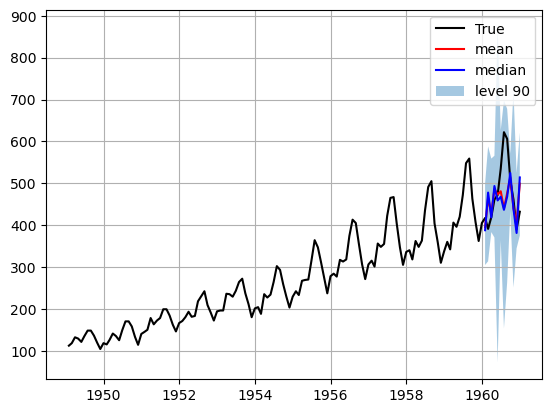

In [ ]:
#| eval: false
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
#from neuralforecast.models import DeepAR
from neuralforecast.losses.pytorch import DistributionLoss, HuberMQLoss
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

#AirPassengersPanel['y'] = AirPassengersPanel['y'] + 10
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[DeepNPTS(h=12,
                   input_size=12,
                   trajectory_samples=100,
                   loss=GMM(),
                #    learning_rate=1e-5,
                   n_layers = 2,
                   dropout=0.0,
                   stat_exog_list=['airline1'],
                   futr_exog_list=['trend'],
                   max_steps=1000,
                   val_check_steps=10,
                   early_stop_patience_steps=3,
                   scaler_type='robust',
                   enable_progress_bar=True),
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['DeepNPTS'], c='red', label='mean')
plt.plot(plot_df['ds'], plot_df['DeepNPTS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['DeepNPTS-lo-90'][-12:].values, 
                 y2=plot_df['DeepNPTS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()